In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Load KMNIST data
X_tr = np.load("kmnist_exp/kmnist-train-imgs.npz")["arr_0"]
y_tr = np.load("kmnist_exp/kmnist-train-labels.npz")["arr_0"]
X_te = np.load("kmnist_exp/kmnist-test-imgs.npz")["arr_0"]
y_te = np.load("kmnist_exp/kmnist-test-labels.npz")["arr_0"]

# Reshape for patching: (N, 1, 28, 28), normalize
X_train = torch.tensor(X_tr.reshape(-1, 1, 28, 28) / 255.0, dtype=torch.float32)
y_train = torch.tensor(y_tr, dtype=torch.long)
X_test = torch.tensor(X_te.reshape(-1, 1, 28, 28) / 255.0, dtype=torch.float32)
y_test = torch.tensor(y_te, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=256)

## Simple Vision Transformer (ViT)

- Split each 28x28 image into 7x7 patches of size 4x4 → 49 patches
- Each patch is linearly embedded into a 64-dim vector
- Prepend a learnable [CLS] token
- Add learnable positional embeddings
- Pass through 4 transformer encoder layers (4 heads, dim=64)
- Classify using the [CLS] token output

In [3]:
class SimpleViT(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_channels=1,
                 embed_dim=64, num_heads=4, num_layers=4, num_classes=10):
        super().__init__()
        self.patch_size = patch_size
        num_patches = (img_size // patch_size) ** 2  # 49
        patch_dim = in_channels * patch_size * patch_size  # 16

        self.patch_embed = nn.Linear(patch_dim, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim) * 0.02)
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads,
            dim_feedforward=embed_dim * 2, dropout=0.1,
            activation="gelu", batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        p = self.patch_size
        # Extract patches: (B, 1, 28, 28) -> (B, 49, 16)
        x = x.unfold(2, p, p).unfold(3, p, p)  # (B, 1, 7, 7, 4, 4)
        x = x.contiguous().reshape(B, -1, p * p)  # (B, 49, 16)

        x = self.patch_embed(x)  # (B, 49, 64)
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)  # (B, 50, 64)
        x = x + self.pos_embed

        x = self.transformer(x)
        return self.head(x[:, 0])  # classify from [CLS] token


device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleViT().to(device)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Device: {device}")

Parameters: 138,890
Device: cuda


In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

for epoch in range(15):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        loss = loss_fn(model(X_batch), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(X_batch)
    print(f"Epoch {epoch+1:2d} | Loss: {total_loss / len(X_train):.4f}")

c:\Users\rohan\anaconda3\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch  1 | Loss: 1.8719
Epoch  2 | Loss: 0.9593
Epoch  3 | Loss: 0.7028
Epoch  4 | Loss: 0.5866
Epoch  5 | Loss: 0.5148
Epoch  6 | Loss: 0.4637
Epoch  7 | Loss: 0.4246
Epoch  8 | Loss: 0.3915
Epoch  9 | Loss: 0.3639
Epoch 10 | Loss: 0.3356
Epoch 11 | Loss: 0.3110
Epoch 12 | Loss: 0.2918
Epoch 13 | Loss: 0.2787
Epoch 14 | Loss: 0.2610
Epoch 15 | Loss: 0.2542


In [5]:
model.eval()
correct = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        correct += (model(X_batch).argmax(1) == y_batch).sum().item()
print(f"ViT Test accuracy: {correct / len(X_test):.4f}")

ViT Test accuracy: 0.8505


### Visualizing Attention Maps

Extract attention weights from the first transformer layer to see what the [CLS] token attends to across patches.

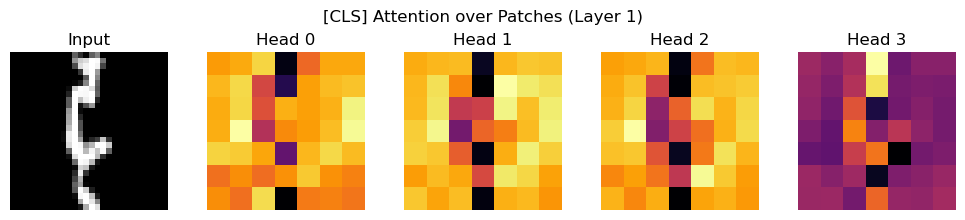

In [6]:
import matplotlib.pyplot as plt

# Extract attention from the first layer for a sample image
sample = X_test[0:1].to(device)
model.eval()

# Forward pass up to transformer input
with torch.no_grad():
    B = 1
    p = model.patch_size
    x = sample.unfold(2, p, p).unfold(3, p, p)
    x = x.contiguous().reshape(B, -1, p * p)
    x = model.patch_embed(x)
    cls = model.cls_token.expand(B, -1, -1)
    x = torch.cat([cls, x], dim=1) + model.pos_embed

    # Get attention weights from first layer's self-attention
    first_layer = model.transformer.layers[0]
    attn_output, attn_weights = first_layer.self_attn(
        x, x, x, need_weights=True, average_attn_weights=False
    )

# attn_weights: (1, num_heads, 50, 50)
# Show CLS token's attention over the 49 patches for each head
attn = attn_weights[0, :, 0, 1:].cpu()  # (num_heads, 49)
num_heads = attn.shape[0]

fig, axes = plt.subplots(1, num_heads + 1, figsize=((num_heads + 1) * 2, 2.2))
axes[0].imshow(sample.cpu().squeeze(), cmap="gray")
axes[0].set_title("Input")
axes[0].axis("off")

for i in range(num_heads):
    attn_map = attn[i].reshape(7, 7)
    axes[i + 1].imshow(attn_map, cmap="inferno")
    axes[i + 1].set_title(f"Head {i}")
    axes[i + 1].axis("off")

plt.suptitle("[CLS] Attention over Patches (Layer 1)", fontsize=12)
plt.tight_layout()
plt.show()